# SRCNN - Batch Normalization & Dropout
This notebook implements the super-resolution convolutional neural network, SRCNN, as described by [Dong *et al.*](https://link.springer.com/chapter/10.1007/978-3-319-10593-2_13).

The notebook will cover two scaling factors described in the paper: $2\times$ and $4\times$. Results for each can be acquired by changing the scaling factor and re-running the notebook.

## Summary
Results from this notebook are summarized in full at the end of the notebook. Using $32 \times 32$ training patches and a scaling factor of 2 or 4, image patch stride of 14, training batch size of 32 with 100 epochs, training took roughly 4 to 6 minutes on a GTX 1080 Ti (depending on architecture).

| Scaling Factor | Image Set | Batch Normalization | Dropout Factor | Mean PSNR | Mean SSIM |
| :------------: | :-------: | :-----------------: | :------------: | :-------: | :-------: |
| 2 | Set14 |  | $None$ | $24.40$ | $0.690$ |
| 2 | Set14 |  | $0.2$ | $21.90$ | $0.647$ |
| 2 | Set14 |  | $0.5$ | $19.68$ | $0.640$ |
| 2 | Set14 | $\checkmark$ | $None$ | $23.95$ | $0.679$ |
| 2 | Set14 | $\checkmark$ | $0.2$ | $23.87$ | $0.679$ |
| 2 | Set14 | $\checkmark$ | $0.5$ | $23.98$ | $0.675$ |
| 4 | Set14 |  | $None$ | $20.79$ | $0.521$ |
| 4 | Set14 |  | $0.2$ | $20.14$ | $0.513$ |
| 4 | Set14 |  | $0.5$ | $15.82$ | $0.450$ |
| 4 | Set14 | $\checkmark$ | $None$ | $20.76$ | $0.518$ |
| 4 | Set14 | $\checkmark$ | $0.2$ | $20.72$ | $0.520$ |
| 4 | Set14 | $\checkmark$ | $0.5$ | $20.72$ | $0.512$ |


As seen in the table, dropout seems to hinder performance on the base model. However, when batch normalization is used, the dropping of nodes does not have the same degradation effect even at $0.5$ fraction dropout. Thus, batch normalization allows us to get a similarly performing model at a smaller size. Of note regarding practical application: images upscaled with models using larger dropout fraction appear darker.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Imports.
import numpy as np
import pandas as pd
from PIL import Image

import site
site.addsitedir('../')
from srcnn_tf2.data.preprocessing import create_xy_patches, import_from_file, scale_batch, center_crop
from srcnn_tf2.data.plotting import n_compare
from srcnn_tf2.model.srcnn_model import SRCNN

# Data locations.
training_folder = '../../../sr_data/T91'
set5_eval_folder = '../../../sr_data/Set5'
set14_eval_folder = '../../../sr_data/Set14'

---
## Import and preprocess training data
High-resolution target images, $I_y$, are 32 x 32 pixel sub-images extracted from the original T91 image set. This is done by passing a 32 x 32 pixel window over the originals at a stride of 14 pixels. Target images are then given a Gaussian blur and downscaled by the scaling factor to produce the low-resolution input images, $I_x$. Each patch is then rotated by 90 degrees 3 times to produce 4 images per patch. Pre-upscaling for the model is performed as part of the model class. 

**Note** that applying the blur after the downscale produces better numerical and visual results on the images that are downscaled for validation (e.g. Set5 and Set14). However, applying the blur before downscaling, as in the paper, while returning seemingly worse numerical and visual results on the validation set, produces far more realistic images when tested on CIFAR-10.

To avoid edge effects of convlution, padding in the model is set to `'valid'`, and $I_y$ images are center cropped to remove the edge, forcing the loss function to compare only the central $20 x 20$ section of the image.

In [3]:
# Data options.
# Note: 'scaling_factor' should evenly divide into 'y_image_size'.
y_image_size = (32, 32)  # Target image size, patches extracted from T91 inputs.
scaling_factor = 2
patch_stride = 14
blur_kernel = -1

# Data extraction.
xdata, ydata = create_xy_patches(training_folder,
                                 scaling_factor,
                                 patch_size=y_image_size,
                                 patch_stride=patch_stride,
                                 blur_kernel=blur_kernel,
                                 rotations=[0, 90, 180, 270], swap_channels=False)
print(f"Target data size (number of images x image shape x channels): {ydata.shape}")
print(f"Training data input size (number of images x image shape x channels): {xdata.shape}")

Target data size (number of images x image shape x channels): (90492, 32, 32, 3)
Training data input size (number of images x image shape x channels): (90492, 16, 16, 3)


## Define and train models
### Define model architectures
Models are defined in a loop, using a range of parameters. Here we do a grid search across the whether or not we use batch normalization, as well as no dropout, and 0.2 and 0.5 fraction dropout.

### Train model architectures
Specify number of epochs and batch size. Use a small split for running validation, and plot the loss and validation loss.

In [4]:
# Model architectures are defined in a list of tuples, containing:
# MODEL PARAMETERS
batch_norm_list = [False, True]
dropout_list = [None, 0.2, 0.5]


arch_list = []

for bn in batch_norm_list:
    for dp in dropout_list:
        arch_list.append((bn, dp))

# Images for testing.
testing_images_14 = import_from_file(set14_eval_folder)

# CIFAR-10 images
from tensorflow.keras.datasets.cifar10 import load_data

# Data import and definition.
d_example_index = {'airplane': 30,
                   'automobile': 32,
                   'bird': 41,
                   'cat': 33,
                   'deer': 34,
                   'dog': 40,
                   'frog': 72,
                   'horse': 37,
                   'ship': 62,
                   'truck': 31}

(x_train, y_train), (x_test, y_test) = load_data()
del x_test
del y_test
del y_train

label_list, im_list = [], []
for di in d_example_index.keys():
    label_list.append(di)
    im_list.append(x_train[d_example_index[di]])

im_list = np.array(im_list) / 255.0
im_scale = center_crop(images=scale_batch(im_list, (im_list.shape[2]*scaling_factor, im_list.shape[1]*scaling_factor)),
                       remove_edge=6)

del x_train
# Save image string.
im_prefix = f'srcnn_baseline_{scaling_factor}x_'

d_pred_images = {
    'Original': im_list,
    'Bicubic': im_scale
}


Training architecture: WITHOUT BN - NO Dropout
100 epochs completed in 4.0 minutes 32.35 seconds, approx. 2.72 seconds per epoch.


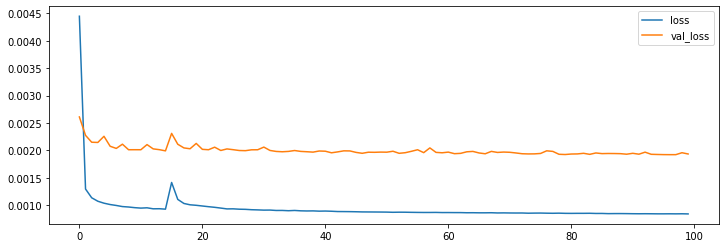

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.4
		5.2. PSNR: 23.4
		5.3. PSNR: 28.3
		5.4. PSNR: 20.8
		5.5. PSNR: 23.7
		5.6. PSNR: 24.8
		5.7. PSNR: 28.6
		5.8. PSNR: 23.6
		5.9. PSNR: 29.0
		5.10. PSNR: 21.7
		5.11. PSNR: 24.1
		5.12. PSNR: 24.6
		5.13. PSNR: 28.0
		5.14. PSNR: 20.6
	Average PSNR: 24.403

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

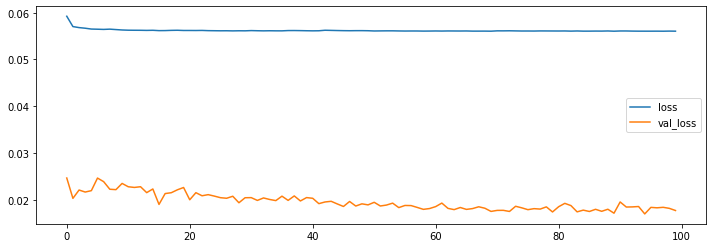

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 19.1
		5.2. PSNR: 21.4
		5.3. PSNR: 25.2
		5.4. PSNR: 18.6
		5.5. PSNR: 22.3
		5.6. PSNR: 22.6
		5.7. PSNR: 24.1
		5.8. PSNR: 21.4
		5.9. PSNR: 24.0
		5.10. PSNR: 20.1
		5.11. PSNR: 21.5
		5.12. PSNR: 22.2
		5.13. PSNR: 25.5
		5.14. PSNR: 18.7
	Average PSNR: 21.902

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.6
		5.3. SSIM: 0.7
		5.4. SSIM: 0

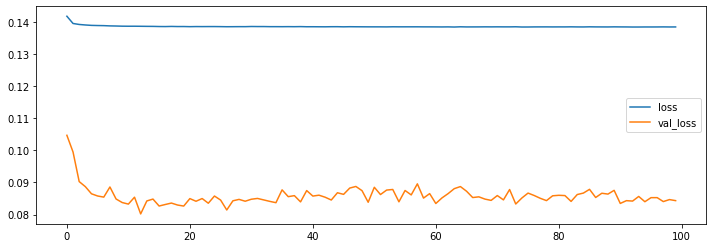

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 19.3
		5.2. PSNR: 17.9
		5.3. PSNR: 22.5
		5.4. PSNR: 17.0
		5.5. PSNR: 20.7
		5.6. PSNR: 19.0
		5.7. PSNR: 21.1
		5.8. PSNR: 18.2
		5.9. PSNR: 21.9
		5.10. PSNR: 16.4
		5.11. PSNR: 21.5
		5.12. PSNR: 19.4
		5.13. PSNR: 22.6
		5.14. PSNR: 18.1
	Average PSNR: 19.684

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.6
		5.3. SSIM: 0.7
		5.4. SSIM: 0

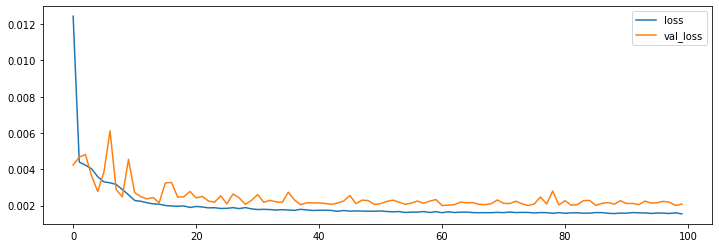

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.2
		5.2. PSNR: 23.0
		5.3. PSNR: 27.2
		5.4. PSNR: 20.0
		5.5. PSNR: 23.6
		5.6. PSNR: 24.5
		5.7. PSNR: 27.0
		5.8. PSNR: 23.2
		5.9. PSNR: 28.4
		5.10. PSNR: 22.0
		5.11. PSNR: 23.6
		5.12. PSNR: 24.7
		5.13. PSNR: 27.5
		5.14. PSNR: 20.3
	Average PSNR: 23.952

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

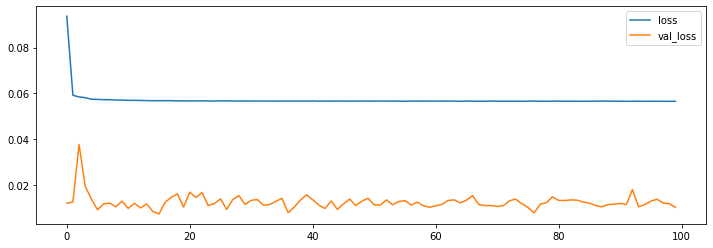

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.2
		5.2. PSNR: 22.8
		5.3. PSNR: 27.0
		5.4. PSNR: 20.5
		5.5. PSNR: 23.2
		5.6. PSNR: 24.4
		5.7. PSNR: 28.2
		5.8. PSNR: 23.4
		5.9. PSNR: 28.4
		5.10. PSNR: 21.0
		5.11. PSNR: 23.6
		5.12. PSNR: 23.3
		5.13. PSNR: 27.8
		5.14. PSNR: 20.4
	Average PSNR: 23.866

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

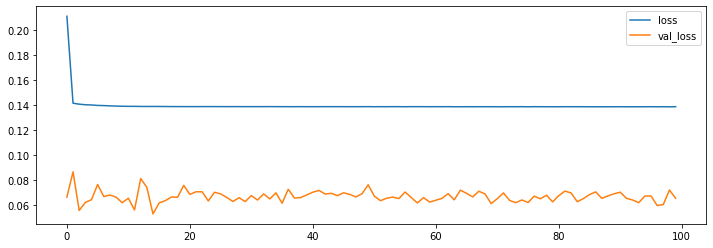

-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: PSNR

	5. PSNR results:
		5.1. PSNR: 20.2
		5.2. PSNR: 23.2
		5.3. PSNR: 27.7
		5.4. PSNR: 20.5
		5.5. PSNR: 23.0
		5.6. PSNR: 24.4
		5.7. PSNR: 27.6
		5.8. PSNR: 23.4
		5.9. PSNR: 27.9
		5.10. PSNR: 21.6
		5.11. PSNR: 23.7
		5.12. PSNR: 24.1
		5.13. PSNR: 27.8
		5.14. PSNR: 20.4
	Average PSNR: 23.976

	6. Plotting PSNR results:
-------------------------------------------------------------------
Starting model benchmark...

	1. Scaling test images to divide evenly by model scaling factor: 2

	2. Downscaling and blurring test images for prediction input.

	3. Predicting images using model.

	4. Calculating metric: SSIM

	5. SSIM results:
		5.1. SSIM: 0.4
		5.2. SSIM: 0.7
		5.3. SSIM: 0.7
		5.4. SSIM: 0

In [5]:
n_epochs = 100
b_size = 64
d_results = {}

for arch in arch_list:
    model = SRCNN(num_channels=3, f1=9, f3=5, n1=64, n2=32, nlin_layers=1,
                  activation='relu', optimizer='adam', loss='mse', metrics=['accuracy'], padding='valid',
                  batch_norm=arch[0], dropout=arch[1])
    print(f"\nTraining architecture: {'WITH BN' if arch[0] else 'WITHOUT BN'} - {'NO Dropout' if arch[1] is None else str(arch[1])+' Dropout'}")
    model.fit(xdata=xdata, ydata=ydata, epochs=n_epochs, batch_size=b_size, validation_split=0.1, verbose=0)
    model.plot_training(figsize=(12, 4), plot_vars=['loss', 'val_loss'])
    psnr_14, psnr_bicubic_14 = model.benchmark(testing_images_14, metric='psnr', return_metrics=True)
    ssim_14, ssim_bicubic_14 = model.benchmark(testing_images_14, metric='ssim', return_metrics=True)
    d_results[f"{'WITH BN' if arch[0] else 'WITHOUT BN'} - {'NO Dropout' if arch[1] is None else str(arch[1])+' Dropout'}"] = (np.mean(psnr_14),
                                                                                                                               np.mean(psnr_bicubic_14),
                                                                                                                               np.mean(ssim_14),
                                                                                                                               np.mean(ssim_bicubic_14))
    im_pred = model.predict(im_list)
    d_pred_images[arch] = im_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


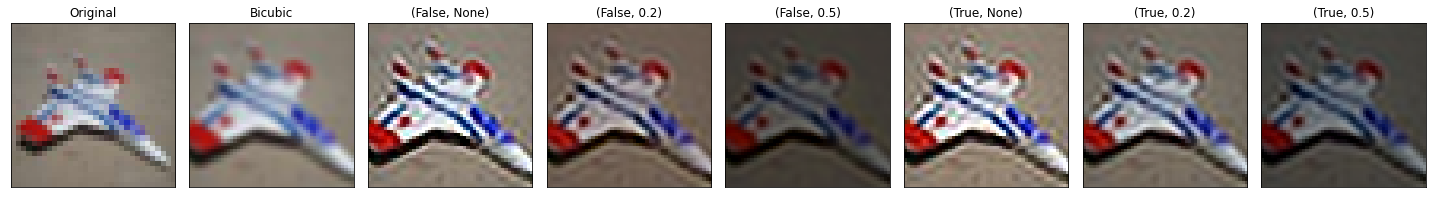

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


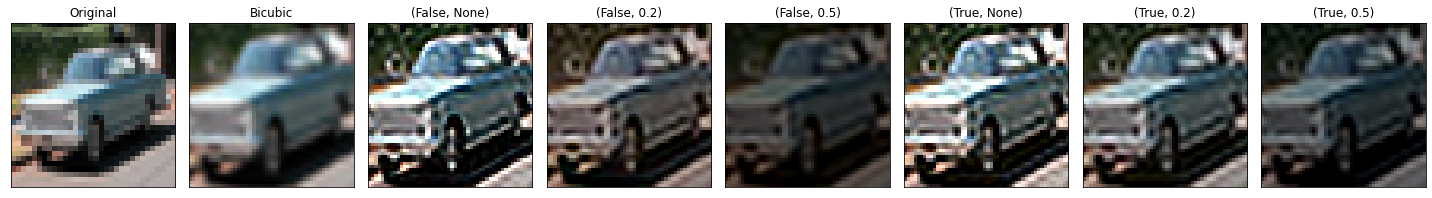

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


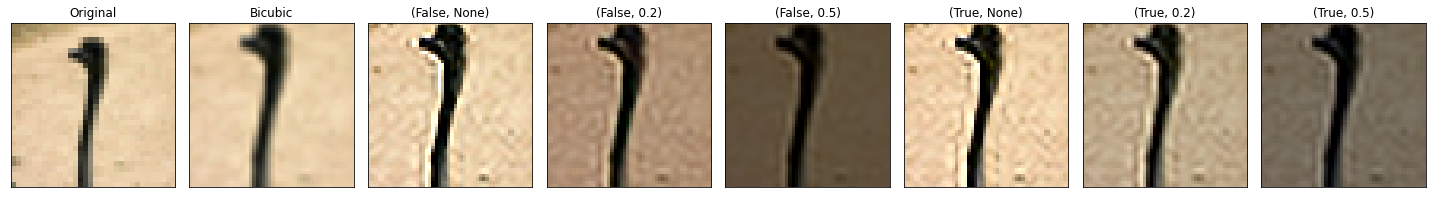

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


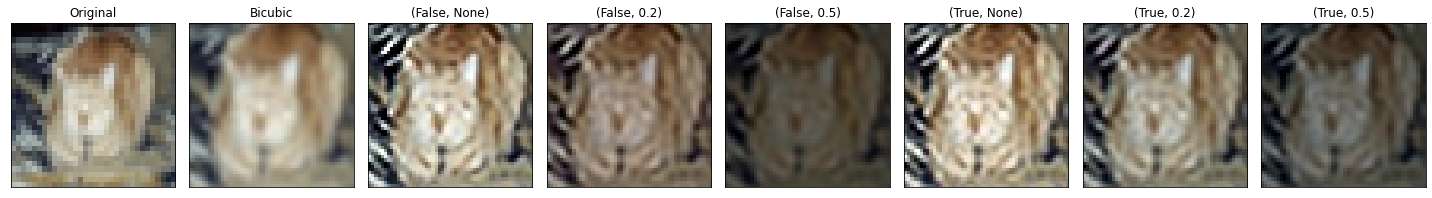

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


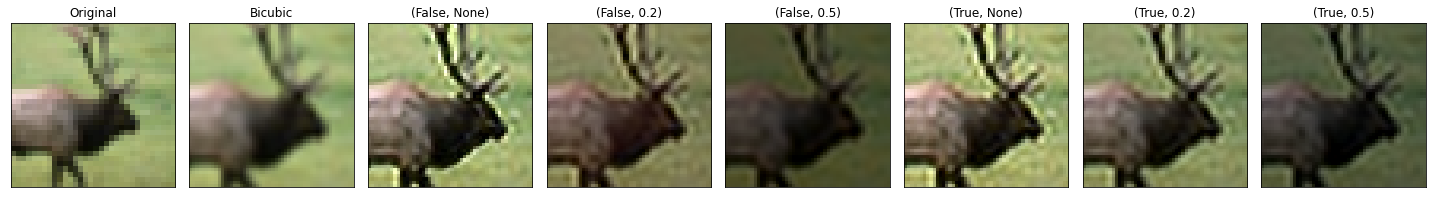

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


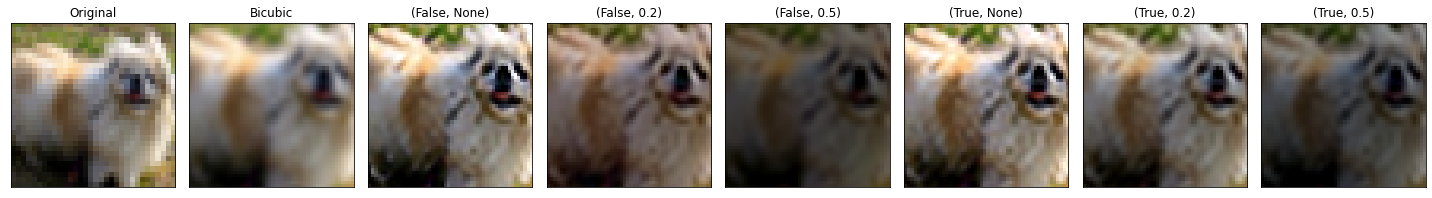

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


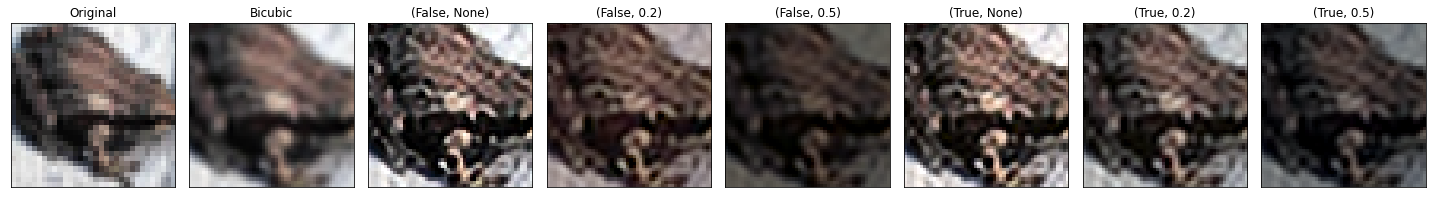

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


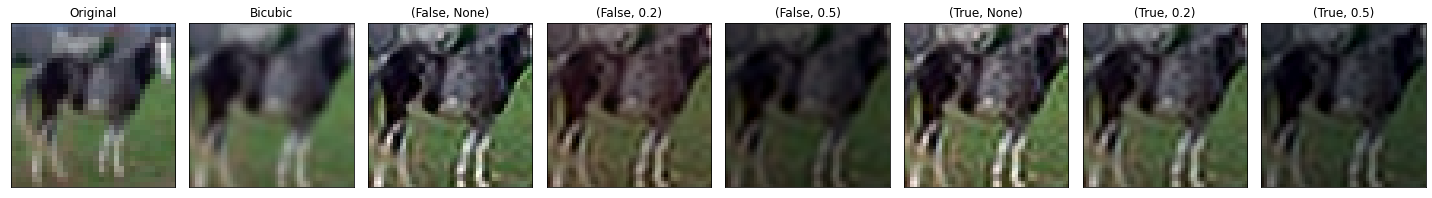

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


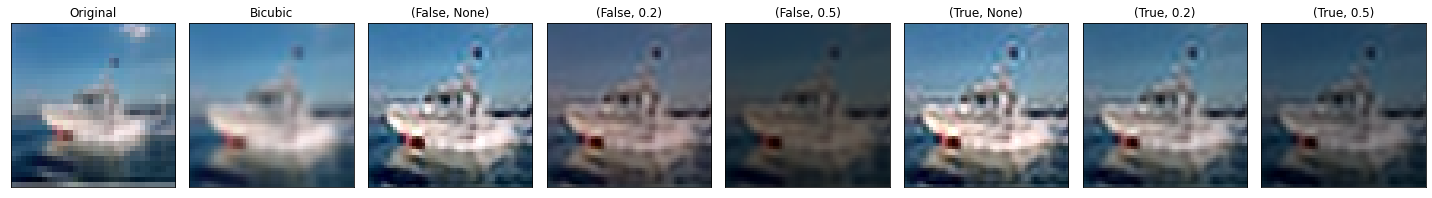

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


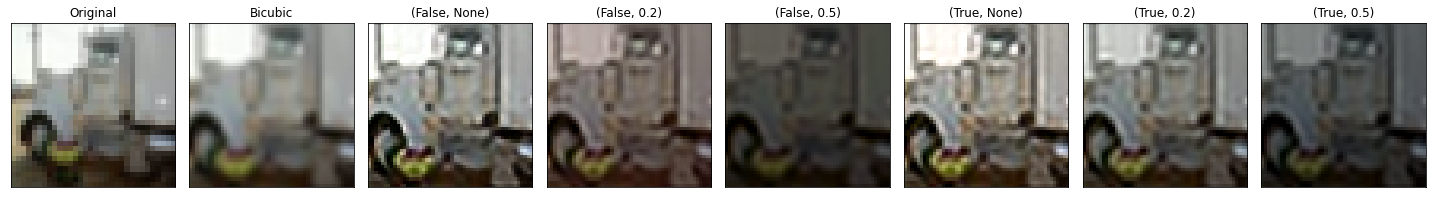

In [6]:
arch_labels = ['Original', 'Bicubic']+arch_list

for i, label in enumerate(label_list):
    image_list = [d_pred_images[a][i] for a in arch_labels]
    n_compare(
    im_list=image_list,
    label_list=[str(a) for a in arch_labels],
    figsize=(20,5)
    )

In [7]:
for d, im in d_pred_images.items():
    print(f"{d} range [{im.min()} - {im.max()}]")

Original range [0.0 - 1.0]
Bicubic range [0.0 - 1.0]
(False, None) range [0.0 - 1.6143598556518555]
(False, 0.2) range [0.0 - 0.9100567102432251]
(False, 0.5) range [0.0 - 0.47855186462402344]
(True, None) range [0.0 - 1.3259919881820679]
(True, 0.2) range [0.0 - 1.032930850982666]
(True, 0.5) range [0.0 - 0.6055712699890137]


In [8]:
for i, a in enumerate(arch_list):
    r_string = f"{'WITH BN' if a[0] else 'WITHOUT BN'} - {'NO Dropout' if a[1] is None else str(a[1])+' Dropout'}"
    print(f"| {scaling_factor} | Set14 | {'$checkmark$' if a[0] else ''} | ${'None' if a[1] is None else str(a[1])}$ | ${d_results[r_string][0]:.2f}$ | ${d_results[r_string][2]:.3f}$ |")

| 2 | Set14 |  | $None$ | $24.40$ | $0.690$ |
| 2 | Set14 |  | $0.2$ | $21.90$ | $0.647$ |
| 2 | Set14 |  | $0.5$ | $19.68$ | $0.640$ |
| 2 | Set14 | $checkmark$ | $None$ | $23.95$ | $0.679$ |
| 2 | Set14 | $checkmark$ | $0.2$ | $23.87$ | $0.679$ |
| 2 | Set14 | $checkmark$ | $0.5$ | $23.98$ | $0.675$ |


In [27]:
np.mean(psnr_14)

20.792572

---
## CIFAR-10 Examples
We use the CIFAR-10 dataset as a "real world" application where there is no target with which to compare. We upscale using both the trained SRCNN and bicubic interpolation, and compare visually (there is no metric in this case).

Images are saved with tags so they can be included in the summary and compare across the three scaling factors.

In [34]:
from tensorflow.keras.datasets.cifar10 import load_data

# Data import and definition.
d_example_index = {'airplane': 30,
                   'automobile': 32,
                   'bird': 41,
                   'cat': 33,
                   'deer': 34,
                   'dog': 40,
                   'frog': 72,
                   'horse': 37,
                   'ship': 62,
                   'truck': 31}

(x_train, y_train), (x_test, y_test) = load_data()
del x_test
del y_test
del y_train

label_list, im_list = [], []
for di in d_example_index.keys():
    label_list.append(di)
    im_list.append(x_train[d_example_index[di]])

im_list = np.array(im_list) / 255.0

del x_train
# Save image string.
im_prefix = f'srcnn_baseline_{scaling_factor}x_'

In [35]:
im_pred = srcnn_model.predict(im_list)
im_scale = center_crop(
    images=scale_batch(im_list, (im_list.shape[2]*scaling_factor, im_list.shape[1]*scaling_factor)),
    remove_edge=(im_list.shape[1]*scaling_factor - im_pred.shape[1])//2)

print((im_list.shape[1]*scaling_factor - im_pred.shape[1])//2, im_list.shape[1]*scaling_factor, im_pred.shape[1])

6 64 52


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


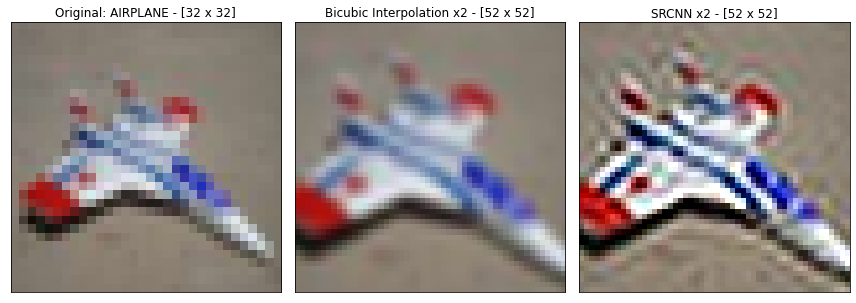

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


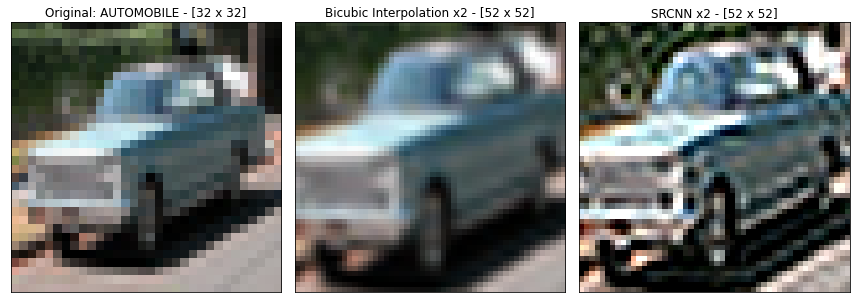

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


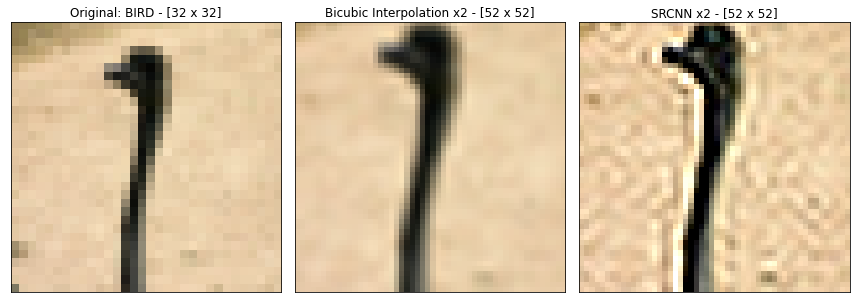

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


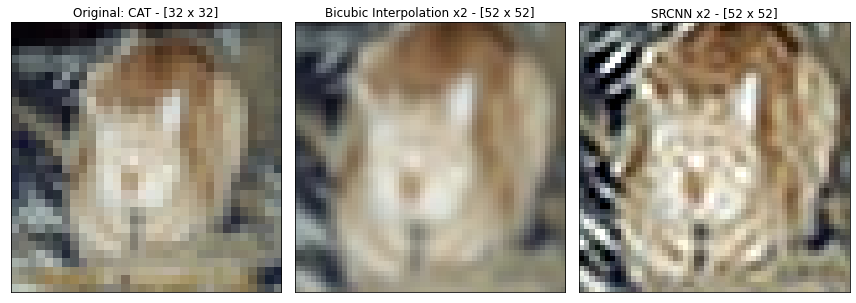

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


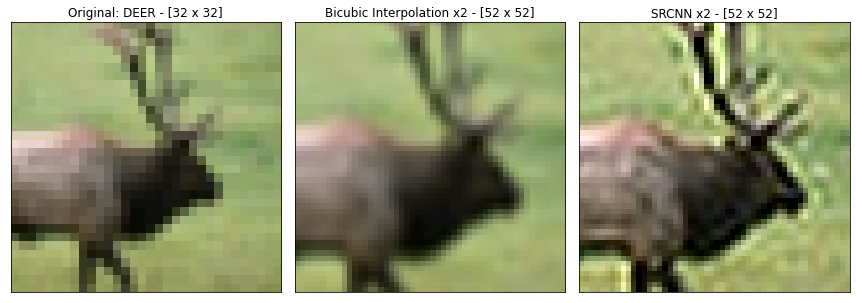

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


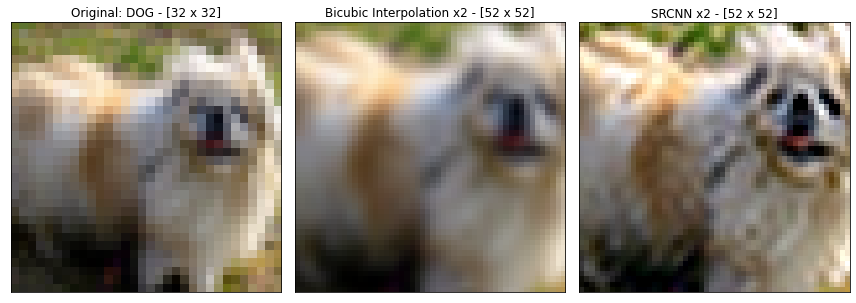

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


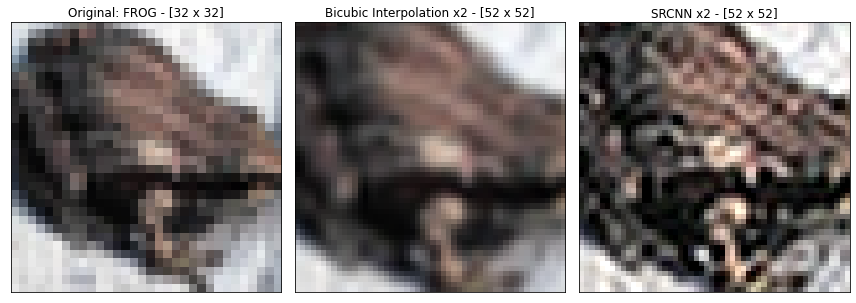

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


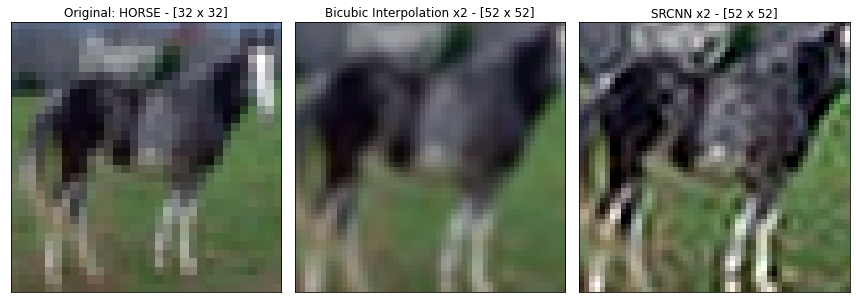

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


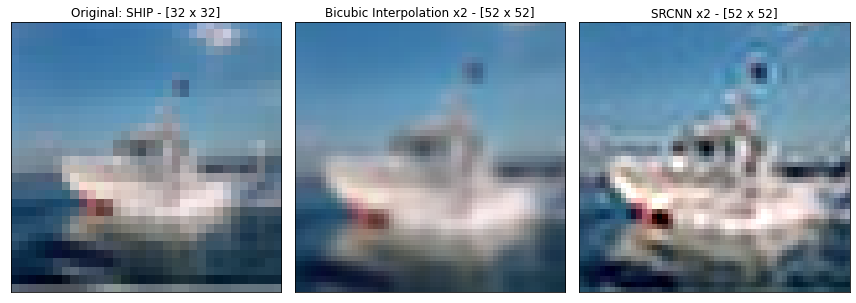

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


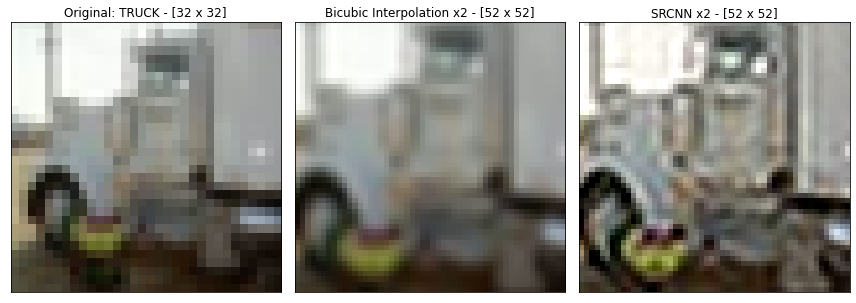

In [36]:
for label, image_raw, image_pred, image_scale in zip(label_list, list(im_list), list(im_pred), list(im_scale)):
    n_compare(
        im_list=[image_raw, image_scale, image_pred],
        label_list=[f'Original: {label.upper()} - [{image_raw.shape[1]} x {image_raw.shape[0]}]',
                    f'Bicubic Interpolation x{scaling_factor} - [{image_scale.shape[1]} x {image_scale.shape[0]}]',
                    f'SRCNN x{scaling_factor} - [{image_pred.shape[1]} x {image_pred.shape[0]}]'],
        figsize=(12,5))
    
    im = Image.fromarray(np.uint8(image_pred*255))
    im.save(f"results/{im_prefix}{label}.png")